In [1]:
import os
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook as tqdm
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def get_adj_matrix():
    """
    Return current graph topology.
    Adjacent matrix will be used at GCN later

    :return: current graph topology of 301 building 5th floor.
    ex) return =
    [[0, 1, 0, 0, 0, 0, 0, 1],
     [1, 0, 1, 0, 0, 0, 0, 0],
     [0, 1, 0, 1, 0, 0, 0, 0],
     [0, 0, 1, 0, 1, 0, 0, 0],
     [0, 0, 0, 1, 0, 1, 0, 0],
     [0, 0, 0, 0, 1, 0, 1, 0],
     [0, 0, 0, 0, 0, 1, 0, 1],
     [1, 0, 0, 0, 0, 0, 1, 0]]
    """

    arr = [[0]*8 for x in range(8)]
    for i in range(8):
        before, after = (i-1)%8, (i+1)%8
        arr[i][before] = 1
        arr[i][after] = 1
        
    return arr

In [77]:
adj_matrix = get_adj_matrix()
num_nodes = len(adj_matrix)

print('adj matrix')
for row in adj_matrix:
    print(row)
    
print('num_nodes:', num_nodes)

adj matrix
[0, 1, 0, 0, 0, 0, 0, 1]
[1, 0, 1, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 0, 0, 0, 0]
[0, 0, 1, 0, 1, 0, 0, 0]
[0, 0, 0, 1, 0, 1, 0, 0]
[0, 0, 0, 0, 1, 0, 1, 0]
[0, 0, 0, 0, 0, 1, 0, 1]
[1, 0, 0, 0, 0, 0, 1, 0]
num_nodes: 8


In [4]:
# load txt data and apply label
def load_data():
    # load data
    data = []
    print('start read sensorData')
    for i in tqdm(range(num_nodes)):
        curr = np.loadtxt('./data/123456people_320000frame_simple/sensorData_{}.txt'.format(i+1), delimiter=',', dtype=np.int32)
        data.append(curr)

    # data.shape: (time, node, 9)    
    data = np.stack(data, axis=1)
    
    # apply label
    bins=[1, 4, 7]
    data[:, :, 0] = np.digitize(data[:, :, 0], bins)
    print('end read sensorData')
    return data

In [5]:
# 특정 label을 포함한 row의 갯수 확인
def train_example_check():
    data = load_data()
    labels = data[:, :, 0]
    print('number of rows that have label==3:', np.sum(np.any(labels==3, axis=1)))
    print('number of rows that have label==2:', np.sum(np.any(labels==2, axis=1)))
    print('number of rows that have label==1:', np.sum(np.any(labels==1, axis=1)))
    print('number of rows that have label==0:', np.sum(np.any(labels==0, axis=1)))
    print('counts:', np.unique(labels, return_counts=True))
    
train_example_check()

start read sensorData



end read sensorData
number of rows that have label==3: 9239
number of rows that have label==2: 107557
number of rows that have label==1: 187630
number of rows that have label==0: 320000
counts: (array([0, 1, 2, 3], dtype=int32), array([2178103,  251146,  121498,    9253]))


In [6]:
# # temp cell
# data = load_data()

In [7]:
# frame_size = 8
# after = 80
# curr = []
# for t in tqdm(range(data.shape[0])):
#     if t-frame_size-after >= 0 and np.any(data[t, :, 0]==3):
#         curr.append(data[t, :, 0]) # append label
        
# curr = np.array(curr)

In [8]:
# np.unique(curr, return_counts=True)

In [9]:
# np.return

In [10]:
# GCN의 input
# x: (NxF) matrix, F=frame_size*8(sensor bit)
# y: (Nx4) one-hot matrix
# A: (NxN) adj matrix
# GCN에 입력될 형태의 x, y를 가져옴
# frame_size: x의 feature로 사용할 frame_size
# after: after개의 frame 후를 예측

def prepare_data(data, frame_size, after):
    x, y = [], []
    # iterate over row(time)
    for t in tqdm(range(data.shape[0])):
        # label==3을 포함한 frame만 고려
        if not np.any(data[t, :, 0]==3):
            continue
            
        # frame_size만큼 볼 수 없는경우 제외
        if t-frame_size-after < 0:
            continue
            
        curr_x = data[t-frame_size-after+1:t-after+1, :, 1:] # (frame_size, 8(node), 8(sensor))
        curr_x = np.swapaxes(curr_x, 0, 1) # swap axis to (8(node), frame_size, 8(sensor))
        curr_x = np.reshape(curr_x, (8, frame_size*8)) # reshape to (8(node), frame_size*8(sensor))
        curr_y = data[t, :, 0] # shape = (8,)
        curr_y = to_categorical(curr_y) # one-hot encoding
        
        x.append(curr_x)
        y.append(curr_y)
        
    x = np.array(x)
    y = np.array(y)
    
    return x, y

# frame_size와 after에 해당하는 x,y를 가져옴
# file형태로 저장되어있으면 file read, 저장되어있지 않으면 prepare_train_data를 이용해서 직접 가공 및 file write
def get_xy(frame_size, after):
    file_x = './data/123456people_320000frame_simple/gcn_get_xy_x_{}_{}.npy'.format(frame_size, after)
    file_y = './data/123456people_320000frame_simple/gcn_get_xy_y_{}_{}.npy'.format(frame_size, after)
    if os.path.isfile(file_x) and os.path.isfile(file_y):
        x = np.load(file_x)
        y = np.load(file_y)
        return x, y
    else:
        data = load_data()
        x, y = prepare_data(data, frame_size, after)
        np.save(file_x, x)
        np.save(file_y, y)
        return x, y

In [11]:
x, y = get_xy(8, 80)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [12]:
print(x.shape, y.shape)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(9239, 8, 64) (9239, 8, 4)
(5912, 8, 64) (5912, 8, 4)
(1479, 8, 64) (1479, 8, 4)
(1848, 8, 64) (1848, 8, 4)


## model

In [13]:
# return DAD matrix
def norm_matrix(adj_matrix):
    ahat = np.array(adj_matrix) + np.eye(len(adj_matrix))
    dhat_prime = np.diag(1 / np.sqrt(np.sum(ahat, axis=1)))
    return np.matmul(np.matmul(dhat_prime, ahat), dhat_prime) # return DAD

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_history(ta, tl, va, vl):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].set_title('loss')
    ax[0].plot(tl)
    ax[0].plot(vl)
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('loss')
    ax[0].legend(['Train', 'Valid'])
    
    ax[1].set_title('accuracy')
    ax[1].plot(ta)
    ax[1].plot(va)
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('accuracy')
    ax[1].legend(['Train', 'Valid'])
    
    plt.show()

In [32]:
class GCN():
    def __init__(self, input_dim, adj_matrix, learning_rate, batch_size):
        N = len(adj_matrix) # number of nodes in graph
        n_matrix = norm_matrix(adj_matrix) # DAD matrix, shape: (N, N)
        # DAD matrix for batch matrix multiplication, shape: (batch_size, N, N)
        n_matrix_batch = np.tile(np.expand_dims(n_matrix, axis=0), [batch_size, 1, 1]) 
        dim1 = 128 # number of output neurons in first layer
        dim2 = 128 # number of output neurons in second layer
        dim3 = 4 # prediction over 4 class
        init = tf.contrib.layers.xavier_initializer() # xavier_initalizer
        
        self.x = tf.placeholder(tf.float32, [batch_size, N, input_dim])
        self.y = tf.placeholder(tf.float32, [batch_size, N, 4])
        
        self.N = tf.constant(n_matrix, tf.float32) # shape: (N, N)
        self.N_batch = tf.constant(n_matrix_batch, tf.float32) # shape: (batch_size, N, N)
        
        # first layer
        self.W1 = tf.Variable(init([input_dim, dim1]))
        self.L1 = tf.matmul(self.N_batch, self.x) # shape: (batch_size, N, input_dim)
        self.L1 = tf.reshape(self.L1, [batch_size*N, input_dim]) # shape: (batch_size*N, input_dim)
        self.L1 = tf.matmul(self.L1, self.W1) # shape: (batch_size*N, dim1)
        self.L1 = tf.nn.tanh(self.L1)
        self.L1 = tf.reshape(self.L1, [batch_size, N, dim1]) # shape: (batch_size, N, dim1)

        # second layer
        self.W2 = tf.Variable(init([dim1, dim2]))
        self.L2 = tf.matmul(self.N_batch, self.L1) # shape: (batch_size, N, dim1)
        self.L2 = tf.reshape(self.L2, [batch_size*N, dim1]) # shape: (batch_size*N, dim1)
        self.L2 = tf.matmul(self.L2, self.W2) # shape: (batch_size*N, dim2)
        self.L2 = tf.nn.relu(self.L2)
        self.L2 = tf.reshape(self.L2, [batch_size, N, dim2]) # shape: (batch_size, N, dim2)
        
        # last layer
        self.W3 = tf.Variable(init([dim2, dim3]))
        self.L3 = tf.matmul(self.N_batch, self.L2) # shape: (batch_size, N, dim2)
        self.L3 = tf.reshape(self.L3, [batch_size*N, dim2]) # shape: (batch_size*N, dim2)
        self.L3 = tf.matmul(self.L3, self.W3) # shape: (batch_size*N, dim3)
        
        # another tensors
        y = tf.reshape(self.y, [batch_size*N, dim3]) # reshape to (batch_size*N, dim3)
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.L3, labels=y))
        
        optimizer = tf.train.AdamOptimizer(learning_rate)
        self.train_step = optimizer.minimize(self.loss)
        
        correct = tf.equal(tf.argmax(y, axis=1), tf.argmax(self.L3, axis=1))
        self.correct = correct
        self.accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
        pred = tf.reshape(self.L3, [batch_size, N, dim3])
        self.ppred = pred
        self.pred = tf.argmax(pred, axis=2)

In [75]:
def train(x_train, y_train, x_valid, y_valid, x_test, y_test):
    batch_size = 100
    learning_rate = 0.01
    frame_size = 8
    after = 80
    epochs = 1000
    input_dim = frame_size*8
    gcn = GCN(input_dim=input_dim, adj_matrix=adj_matrix,
              learning_rate=learning_rate,
              batch_size=batch_size)
    loss = gcn.loss
    step = gcn.train_step
    pred = gcn.pred
    accuracy = gcn.accuracy
    x = gcn.x
    y = gcn.y
    
    train_acc = []
    train_loss = []
    valid_acc = []
    valid_loss = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in tqdm(range(epochs)):
            
            '''
            propagation rule H' = DADHW 에서
            H가 3d tensor(batch_size, num_nodes, input_dim) 이라서 batch_size를 None으로 줄 수 없고 직접 명시해야함
            또한 그 이유로 인해 한번 network가 정해질 때 batch_size를 parameter로 받아야하며 train 뿐만아니라 validation,
            test의 경우에도 같은 batch_size를 써야함
            밑의 코드가 train set, valid set에 대해서 분리된 이유도 batch_size를 명시해서 돌려야하기 때문
            '''

            # for train set
            rand_idx = np.random.permutation(len(x_train))
            x_shuf = x_train[rand_idx]
            y_shuf = y_train[rand_idx]
            sum_loss = 0.0
            sum_acc = 0.0
            num_iter = int(len(x_shuf) / batch_size)
            for i in range(num_iter):
                start = batch_size*i
                end = batch_size*(i+1)
                l, _, acc = sess.run([loss, step, accuracy], feed_dict={
                    x: x_shuf[start:end],
                    y: y_shuf[start:end],
                })
                sum_loss += l
                sum_acc += acc
                
            avg_loss = sum_loss / num_iter
            avg_acc = sum_acc / num_iter
            train_acc.append(avg_acc)
            train_loss.append(avg_loss)

            
            # for valid set
            rand_idx = np.random.permutation(len(x_valid))
            x_shuf = x_valid[rand_idx]
            y_shuf = y_valid[rand_idx]
            sum_loss = 0.0
            sum_acc = 0.0
            num_iter = int(len(x_shuf) / batch_size)
            for i in range(num_iter):
                start = batch_size*i
                end = batch_size*(i+1)
                l, _, acc = sess.run([loss, step, accuracy], feed_dict={
                    x: x_shuf[start:end],
                    y: y_shuf[start:end],
                })
                sum_loss += l
                sum_acc += acc

            avg_loss = sum_loss / num_iter
            avg_acc = sum_acc / num_iter
            valid_acc.append(avg_acc)
            valid_loss.append(avg_loss)
            
#             print('epoch: %3d, train_loss: %.4f, train_acc: %.4f, valid_loss: %.4f, valid_acc: %.4f' %
#                   (epoch, train_loss[-1], train_acc[-1], valid_loss[-1], valid_acc[-1]))
            

    
        # for test
        num_iter = int(len(x_test) / batch_size)
        sum_loss = 0.0
        sum_acc = 0.0
        trues = np.array([0,0,0,0]) # for answer statistics
        falses = np.array([0,0,0,0]) # for answer statistics
        total_num = 0
        for i in range(num_iter):
            start = batch_size*i
            end = batch_size*(i+1)
            l, acc, cor, pre, ppre = sess.run([loss, accuracy, gcn.correct,
                                               pred, gcn.ppred], feed_dict={
                x: x_test[start:end],
                y: y_test[start:end],
            })
            
            sum_loss += l
            sum_acc += acc
            
            answer = np.argmax(y_test[start:end], axis=2).reshape(-1) # shape: (batch_size*N)
            total_num += answer.shape[0]
            for _ in range(answer.shape[0]):
                curr = answer[_]
                if cor[_]:
                    trues[curr] += 1
                else:
                    falses[curr] += 1
            
            
        avg_loss = sum_loss / num_iter
        avg_acc = sum_acc / num_iter
        
        print('min train loss:', min(train_loss))
        print('loss, acc on test:', avg_loss, avg_acc)
        for i in range(4):
            print('label %d: %d/%d' % (i, trues[i], (trues+falses)[i]))
        print('accuracy:', np.sum(trues)/(np.sum(trues)+np.sum(falses)))
        print('total_num:', total_num)
        print('pred=============')
        print(np.unique(pre, return_counts=True))
        print(ppre)
    return train_acc, train_loss, valid_acc, valid_loss

min train loss: 0.7017559116169557
loss, acc on test: 2.246530340777503 0.7121527791023254
label 0: 10000/11387
label 1: 48/920
label 2: 9/291
label 3: 198/1802
accuracy: 0.7121527777777777
total_num: 14400
pred=============
(array([0, 1, 2, 3]), array([685,  33,   9,  73]))
[[[  2.8812082   -0.6785673   -4.246268    -0.43306816]
  [  3.3614092   -0.7916615   -4.9539785   -0.5052464 ]
  [  2.881208    -0.6785673   -4.246268    -0.43306816]
  ...
  [  0.           0.           0.           0.        ]
  [  0.4802013   -0.11309437  -0.70771104  -0.07217829]
  [  1.440604    -0.3392831   -2.1231332   -0.2165348 ]]

 [[  0.           0.           0.           0.        ]
  [  0.           0.           0.           0.        ]
  [  0.           0.           0.           0.        ]
  ...
  [  0.           0.           0.           0.        ]
  [  0.           0.           0.           0.        ]
  [  0.           0.           0.           0.        ]]

 [[  3.922316    -1.2857099  -19.404

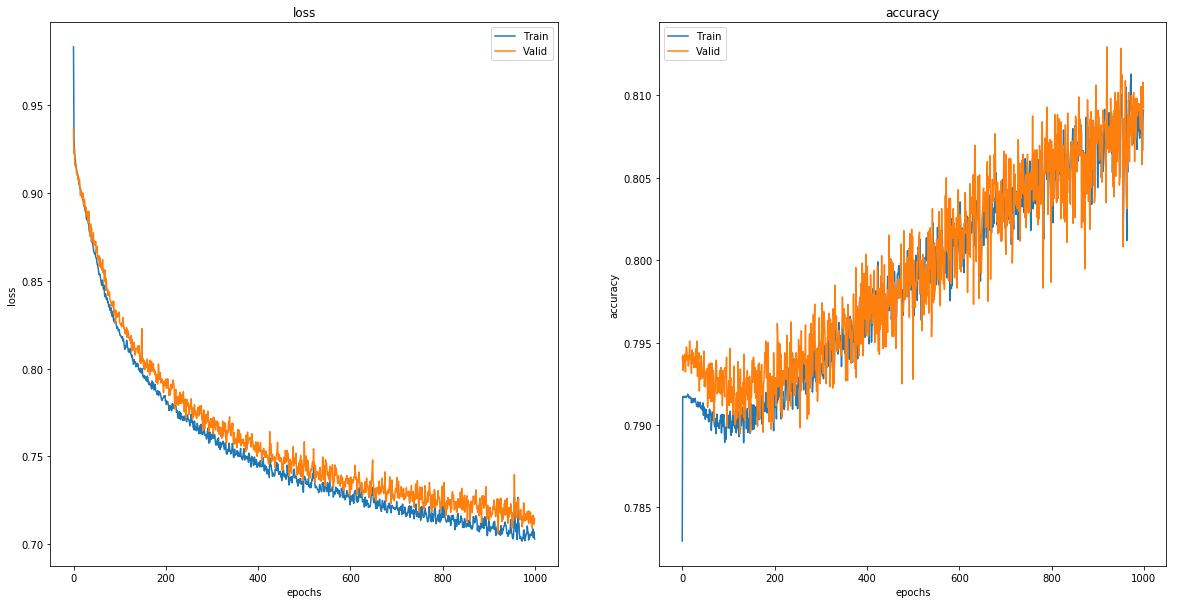

In [76]:
for i in range(1):
    x, y = get_xy(8, 80)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)
    ta, tl, va, vl = train(x_train, y_train, x_valid, y_valid, x_test, y_test)
    plot_history(ta, tl, va, vl)